In [40]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from circuit_knitting.utils.simulation import ExactSampler

exact_sampler = ExactSampler()

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
from qiskit.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.library import XGate, YGate, CXGate
service = QiskitRuntimeService()

from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement

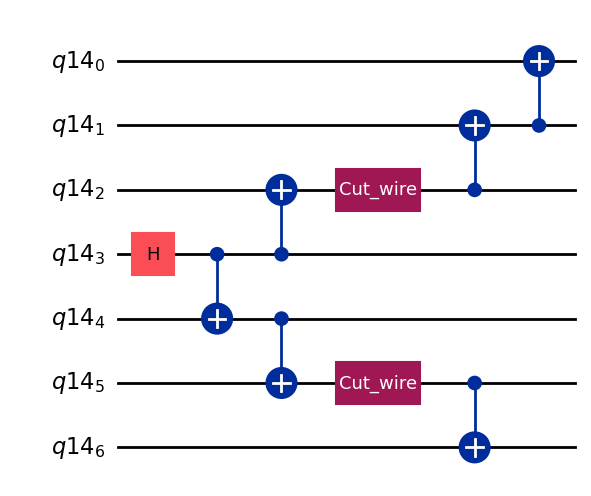

In [41]:
#qc = get_ghz_circ_static(num_qubit=6)
num_qubit=7
qr=QuantumRegister(num_qubit)
cr2=ClassicalRegister(num_qubit,name="cr2")                     
qc=QuantumCircuit(qr)
qc.h(3)
qc.cx(3,4)
qc.cx(3,2)

qc.cx(4,5)
qc.append(CutWire(), [5])
qc.append(CutWire(), [2])
qc.cx(2,1)
qc.cx(1,0)
qc.cx(5,6)
qc.draw("mpl")

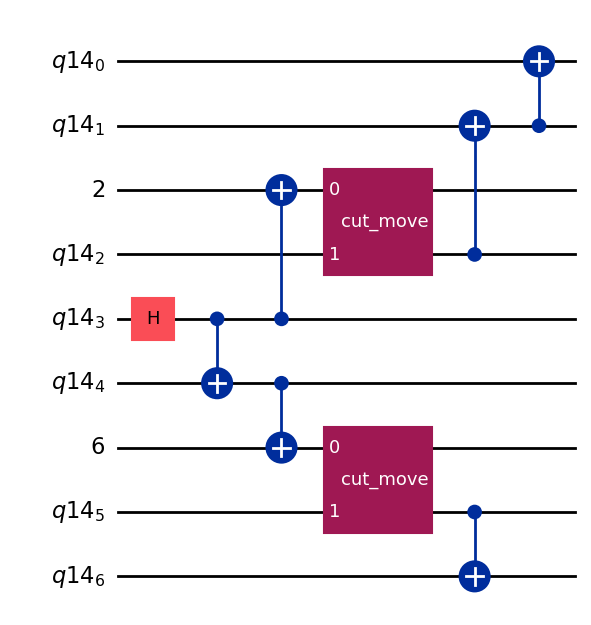

In [42]:
observable = SparsePauliOp(["ZIIIIII"])
qc_1 = cut_wires(qc)
qc_1.draw("mpl")

In [43]:
observable_expanded_paulis = expand_observables(observable.paulis, qc, qc_1)
observable_expanded_paulis

PauliList(['ZIIIIIIII'])

In [44]:
partitioned_problem = partition_problem(
    circuit=qc_1, observables=observable_expanded_paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['III']), 1: PauliList(['IIII']), 2: PauliList(['ZI'])}

In [51]:
partitioned_problem

PartitionedCuttingProblem(subcircuits={0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C5D31A2750>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C5D341FB10>, 2: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C5D3281A50>}, bases=[<circuit_knitting.cutting.qpd.qpd_basis.QPDBasis object at 0x000001C5D2F63390>, <circuit_knitting.cutting.qpd.qpd_basis.QPDBasis object at 0x000001C5D329A210>], subobservables={0: PauliList(['III']), 1: PauliList(['IIII']), 2: PauliList(['ZI'])})

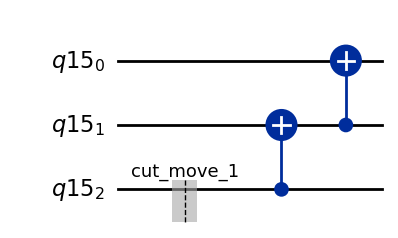

In [45]:
subcircuits[0].draw("mpl")

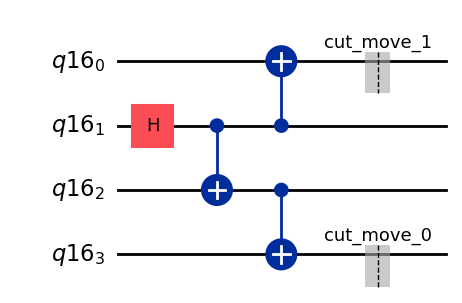

In [46]:
subcircuits[1].draw("mpl")

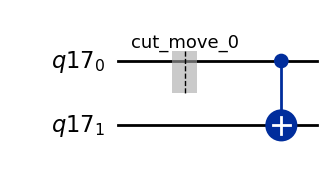

In [47]:
subcircuits[2].draw("mpl")

In [48]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=1024,
)

results = {
    label: exact_sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}

In [49]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

In [50]:
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc.decompose("cut_wire"), observable)]).result()[0].data.evs
)
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.0
Exact expectation value: 0.0
Error in estimation: 0.0
Relative error in estimation: nan


C:\Users\shikh\AppData\Local\Temp\ipykernel_69116\1330935100.py:9: RuntimeWarning: invalid value encountered in divide
  f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
